In [121]:
!pip install AdvancedAnalytics

# **IMPORTING THE PACKAGES**

In [122]:
import time
import pandas as pd
import numpy as  np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from AdvancedAnalytics.ReplaceImputeEncode import DT, ReplaceImputeEncode
from AdvancedAnalytics.Forest              import forest_classifier
from AdvancedAnalytics.Tree                import tree_classifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE  # Import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from copy import deepcopy
pd.set_option('display.max_columns', 500)

In [123]:
# Load the dataset
file_path = 'diabetes_dataset.csv'
db_data = pd.read_csv(file_path)
print("These data contain", db_data.shape[0], "cases with", db_data.shape[1],
      "attributes.")
# Display the first few rows of the dataset to examine its structure
db_data.head()


These data contain 768 cases with 9 attributes.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [124]:
attribute_map = {
    'Pregnancies': [DT.Interval, (1,17)],
    'Glucose': [DT.Interval, (44,199)],
    'BloodPressure': [DT.Interval, (24,122)],
    'SkinThickness': [DT.Interval, (7, 99)],
    'Insulin': [DT.Interval, (14, 846)],
    'BMI': [DT.Interval, (18.2, 67.1)],
    'DiabetesPedigreeFunction': [DT.Interval, (0.078, 2.42)],
    'Age': [DT.Interval, (21, 81)],
    'Outcome' : [DT.Binary, (0, 1)]
}

# **Data Preprocessing using ReplaceImputeEncode (RIE)**

In [125]:
""" ************************************************************************ """
"""    DATA PREPROCESSING - MANAGE MISSING VALUES, OUTLIERS AND APPLY ANY
                            NEEDED ENCODING OR TAANSFORMATIONS               """
""" ************************************************************************ """
print("\n*********************************************************************")
print("***************** DATA PREPROCESSING USING RIE **********************")
print("*********************************************************************")
target = 'Outcome'
rie = ReplaceImputeEncode(data_map=attribute_map, binary_encoding="one-hot",
                          nominal_encoding="one-hot", no_impute=[target],
                          drop=False, display=True)

#features_map = rie.draft_features_map(db_data)
encoded_db_data = rie.fit_transform(db_data)
display(encoded_db_data)

y = encoded_db_data[target] # The zero_one sklearn function requires encoding
X = encoded_db_data.drop(target,axis=1)

n_folds  = 4
p_val    = 1.0/n_folds #Proportion of Data used for Validation
Xt, Xv, yt, yv = train_test_split(X, y, test_size=p_val, random_state=12345)

col = []
for name in X.columns:
    if name==target:
        continue
    col.append(name)


*********************************************************************
***************** DATA PREPROCESSING USING RIE **********************
*********************************************************************

********** Data Preprocessing ***********
Features Dictionary Contains:
8 Interval, 
1 Binary, 
0 Nominal, and 
0 Excluded Attribute(s).

Data contains 768 observations & 9 columns.


Attribute Counts
............................... Missing  Outliers
Pregnancies...............         0       111
Glucose...................         0         5
BloodPressure.............         0        35
SkinThickness.............         0       227
Insulin...................         0       374
BMI.......................         0        11
DiabetesPedigreeFunction..         0         0
Age.......................         0         0
Outcome...................         0         0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000000,148.0,72.0,35.00000,155.548223,33.6,0.627,50.0,1
1,1.000000,85.0,66.0,29.00000,155.548223,26.6,0.351,31.0,0
2,8.000000,183.0,64.0,29.15342,155.548223,23.3,0.672,32.0,1
3,1.000000,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0
4,4.494673,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.000000,101.0,76.0,48.00000,180.000000,32.9,0.171,63.0,0
764,2.000000,122.0,70.0,27.00000,155.548223,36.8,0.340,27.0,0
765,5.000000,121.0,72.0,23.00000,112.000000,26.2,0.245,30.0,0
766,1.000000,126.0,60.0,29.15342,155.548223,30.1,0.349,47.0,1


In [126]:
# Replace zeros with NaN in columns where zero does not make sense
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
db_data[columns_to_replace] = db_data[columns_to_replace].replace(0, np.nan)

# Fill missing values with the mean of each column
db_data.fillna(db_data.mean(), inplace=True)


In [127]:

# Identify predictor variables
target = 'Outcome'
predictors = list(db_data.columns.drop(target))


# **LOGISTIC REGRESSION MODEL**

In [128]:
import statsmodels.api as sm
rie = ReplaceImputeEncode(data_map=attribute_map, binary_encoding="one-hot",
                          nominal_encoding="one-hot", no_impute=[target],
                          drop=False, display=True)

encoded_db_data = rie.fit_transform(db_data)
X = encoded_db_data.drop(columns=[target])  # Independent variables (features)
y = encoded_db_data[target]  # Dependent variable (target)
# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the summary of the logistic regression
print(result.summary())


********** Data Preprocessing ***********
Features Dictionary Contains:
8 Interval, 
1 Binary, 
0 Nominal, and 
0 Excluded Attribute(s).

Data contains 768 observations & 9 columns.


Attribute Counts
............................... Missing  Outliers
Pregnancies...............         0       111
Glucose...................         0         0
BloodPressure.............         0         0
SkinThickness.............         0         0
Insulin...................         0         0
BMI.......................         0         0
DiabetesPedigreeFunction..         0         0
Age.......................         0         0
Outcome...................         0         0
Optimization terminated successfully.
         Current function value: 0.464153
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:            

# **STEPWISE LOGISIC REGRESSION MODEL**


In [129]:
# Target and feature selection
target = 'Outcome'
y  = encoded_db_data[target]  # Use unencoded values for target. Sklearn uses these labels
X  = encoded_db_data.drop(target, axis=1)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12345)

# Stepwise Selection Function
def stepwise_selection(X, y, method='forward', n_features_to_select=None, feature_names=None):
    """Performs stepwise feature selection using RFE."""

    model = LogisticRegression(max_iter=1000, solver='lbfgs')

    # Use Recursive Feature Elimination (RFE)
    if method == 'forward':
        rfe = RFE(model, n_features_to_select=n_features_to_select, step=1)
        rfe = rfe.fit(X, y)
        print(f"Selected features (forward): {feature_names[rfe.support_]}")
    elif method == 'backward':
        rfe = RFE(model, n_features_to_select=n_features_to_select, step=1)
        rfe = rfe.fit(X, y)
        print(f"Selected features (backward): {feature_names[rfe.support_]}")
    else:
        raise ValueError("Method should be 'forward' or 'backward'")

    return rfe.support_

# Assuming `X_train`, `X_test`, `y_train`, `y_test` are pre-defined and **unscaled**
# Use the original DataFrame feature names for reference
feature_names = X.columns

# Run stepwise selection (e.g., forward selection) on **unscaled** data
selected_features_mask = stepwise_selection(X_train, y_train, method='forward', n_features_to_select=12, feature_names=feature_names)

# Display selected and dropped features
def display_selected_and_dropped_features(rfe_support, feature_names):
    """Creates a table showing selected and dropped features."""
    feature_selection = pd.DataFrame({'Feature': feature_names, 'Selected': rfe_support})

    selected_features = feature_selection[feature_selection['Selected'] == True]['Feature'].tolist()
    dropped_features = feature_selection[feature_selection['Selected'] == False]['Feature'].tolist()

    selected_dropped_df = pd.DataFrame({
        'Selected Features': pd.Series(selected_features),
        'Dropped Features': pd.Series(dropped_features)
    })
    print(selected_dropped_df)

display_selected_and_dropped_features(selected_features_mask, feature_names)


Selected features (forward): Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
          Selected Features Dropped Features
0               Pregnancies              NaN
1                   Glucose              NaN
2             BloodPressure              NaN
3             SkinThickness              NaN
4                   Insulin              NaN
5                       BMI              NaN
6  DiabetesPedigreeFunction              NaN
7                       Age              NaN


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=12 > n_features=8. There will be no feature selection and all features will be kept.
  warnings.warn(


In [130]:
# Train logistic regression model with selected features on **unscaled** data
X_train_selected = X_train.loc[:, selected_features_mask]
X_test_selected = X_test.loc[:, selected_features_mask]
stepwise_selected_features = X_train_selected

# Compute coefficients, p-values, and VIF using StatsModels
def compute_vif_and_stats(X_train_selected, y_train):
    """Computes VIF, coefficients, and p-values using StatsModels."""

    # Add constant for intercept
    X_train_selected_const = sm.add_constant(X_train_selected)

    # Fit logistic regression model using StatsModels
    logit_model = sm.Logit(y_train, X_train_selected_const)
    results = logit_model.fit()

    # Get coefficients and p-values
    coefficients = results.params[1:]  # Exclude the intercept
    p_values = results.pvalues[1:]     # Exclude the intercept

    # Compute VIF
    vif_values = [variance_inflation_factor(X_train_selected_const, i) for i in range(1, X_train_selected_const.shape[1])]

    return coefficients, p_values, vif_values, results.summary(), np.exp(results.params[1:])

coefficients, p_values, vif_values, model_summary, odds_ratios = compute_vif_and_stats(X_train_selected, y_train)

# Display coefficients, p-values, VIF, and Odds Ratios
selected_features_stats = pd.DataFrame({
    'Selected Feature': feature_names[selected_features_mask],
    'Coefficient': coefficients,
    'P-Value': p_values,
    'VIF': vif_values,
    'Odds Ratio': odds_ratios
})

print("*******************************************************************")
print("Selected Features with Coefficients, P-Values, VIF, and Odds Ratios:")
print("*******************************************************************")
print(selected_features_stats)
print(model_summary)
print("*******************************************************************")

# Train logistic regression model using Scikit-learn with the selected features
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_selected, y_train)
stepwise_model = model

# Predict probabilities for ROC and Precision-Recall Curves
y_train_pred_prob = model.predict_proba(X_train_selected)[:, 1]  # Training set probabilities
y_test_pred_prob = model.predict_proba(X_test_selected)[:, 1]    # Test set probabilities

# Convert probabilities into binary predictions using 0.1 as the threshold
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

Optimization terminated successfully.
         Current function value: 0.486864
         Iterations 6
*******************************************************************
Selected Features with Coefficients, P-Values, VIF, and Odds Ratios:
*******************************************************************
                                  Selected Feature  Coefficient       P-Value  \
Pregnancies                            Pregnancies     0.123920  3.081111e-03   
Glucose                                    Glucose     0.034313  1.316252e-14   
BloodPressure                        BloodPressure    -0.012126  2.126337e-01   
SkinThickness                        SkinThickness     0.004738  7.600719e-01   
Insulin                                    Insulin    -0.001350  3.188597e-01   
BMI                                            BMI     0.090060  8.874688e-06   
DiabetesPedigreeFunction  DiabetesPedigreeFunction     0.667080  5.989045e-02   
Age                                          

*******************************************************************
*******************************************************************

Metrics for Training and Test Sets:
                     Metric  Training Set   Test Set
0              Accuracy (%)     75.605214  81.385281
1             Precision (%)     70.253165  80.000000
2  Recall (Sensitivity) (%)     56.923077  54.794521
3           Specificity (%)     86.257310  93.670886
4              F1 Score (%)     62.889518  65.040650
5       Miscalculations (%)     24.394786  18.614719
*******************************************************************
*************


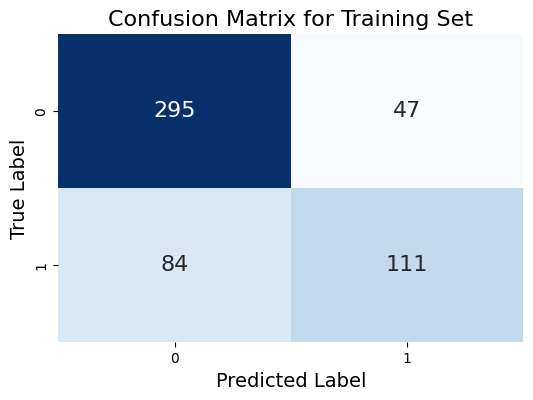

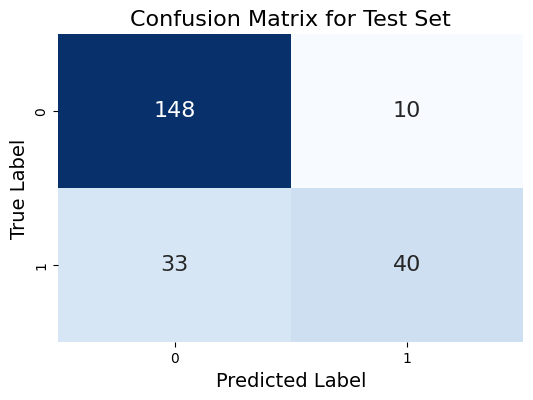

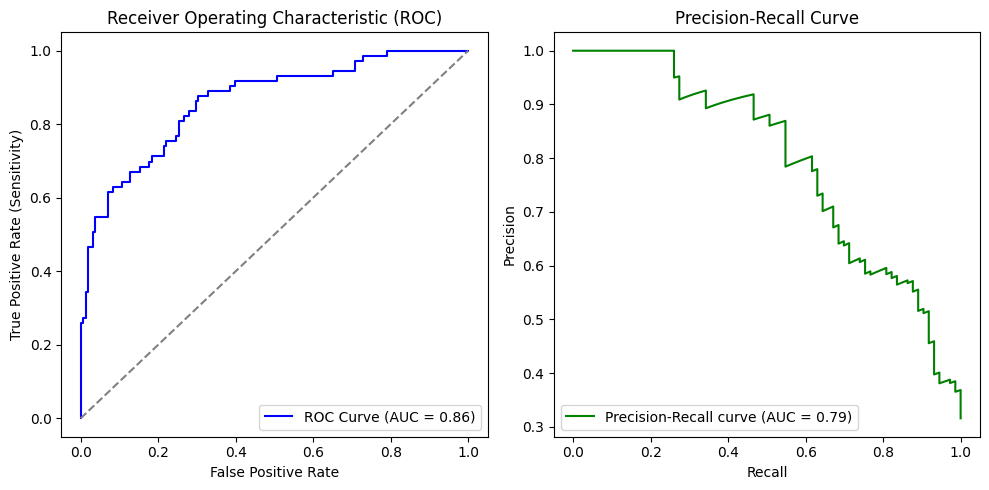

In [131]:
# Calculate metrics for training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
train_precision = precision_score(y_train, y_train_pred) * 100
train_recall = recall_score(y_train, y_train_pred) * 100
train_f1 = f1_score(y_train, y_train_pred) * 100
train_specificity = (conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[0, 1])) * 100
train_miscalculations = (conf_matrix_train[0, 1] + conf_matrix_train[1, 0]) / len(y_train) * 100

# Calculate metrics for test (validation) set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
test_precision = precision_score(y_test, y_test_pred) * 100
test_recall = recall_score(y_test, y_test_pred) * 100
test_f1 = f1_score(y_test, y_test_pred) * 100
test_specificity = (conf_matrix_test[0, 0] / (conf_matrix_test[0, 0] + conf_matrix_test[0, 1])) * 100
test_miscalculations = (conf_matrix_test[0, 1] + conf_matrix_test[1, 0]) / len(y_test) * 100
# Display metrics for both training and test sets side by side
print("*******************************************************************")
print("*******************************************************************")
print("\nMetrics for Training and Test Sets:")
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy (%)', 'Precision (%)', 'Recall (Sensitivity) (%)', 'Specificity (%)', 'F1 Score (%)', 'Miscalculations (%)'],
    'Training Set': [train_accuracy, train_precision, train_recall, train_specificity, train_f1, train_miscalculations],
    'Test Set': [test_accuracy, test_precision, test_recall, test_specificity, test_f1, test_miscalculations]
})
print(metrics_df)
print("*******************************************************************")
print("*************")
# Plot confusion matrix for the training set
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title("Confusion Matrix for Training Set", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

# Plot confusion matrix for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title("Confusion Matrix for Test Set", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()
# Plot ROC and Precision-Recall curves for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Precision-Recall curve for test set
precision_vals_test, recall_vals_test, _ = precision_recall_curve(y_test, y_test_pred_prob)
precision_recall_auc_test = auc(recall_vals_test, precision_vals_test)

# Plot ROC and Precision-Recall curves
plt.figure(figsize=(10, 5))

# Plot ROC curve for test set
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, color='blue', label=f'ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

# Plot Precision-Recall curve for test set
plt.subplot(1, 2, 2)
plt.plot(recall_vals_test, precision_vals_test, color='green', label=f'Precision-Recall curve (AUC = {precision_recall_auc_test:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


# Function to calculate metrics and display confusion matrix (previously defined)
def calculate_metrics(y_true, y_pred, y_prob):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])) * 100
    miscalculations = (conf_matrix[0, 1] + conf_matrix[1, 0]) / len(y_true) * 100

    return accuracy, precision, recall, specificity, f1, miscalculations, conf_matrix

# Stepwise Model Predictions (Assuming you've already trained the stepwise model)
# y_train_pred, y_test_pred: binary predictions (0 or 1)
# y_train_pred_prob, y_test_pred_prob: predicted probabilities for class 1

# Calculate metrics for the stepwise model on the training set
stepwise_train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_prob)

# Calculate metrics for the stepwise model on the test set
stepwise_test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_prob)

# **DECISION TREE**


*********************************************************************
***** DECISION TREE OPTIMIZATION USING N-FOLD CROSS-VALIDATION ******
*********************************************************************

Decision Tree for Depth= 2 Min Split= 2 Min Leaf Size= 1
Metric............  Mean    Std. Dev.
F1V: ............. 0.4845    0.0329

Decision Tree for Depth= 3 Min Split= 2 Min Leaf Size= 1
Metric............  Mean    Std. Dev.
F1V: ............. 0.5380    0.0404

Decision Tree for Depth= 3 Min Split= 2 Min Leaf Size= 4
Metric............  Mean    Std. Dev.
F1V: ............. 0.5394    0.0399

Decision Tree for Depth= 4 Min Split= 2 Min Leaf Size= 1
Metric............  Mean    Std. Dev.
F1V: ............. 0.6645    0.0702

Decision Tree for Depth= 4 Min Split= 2 Min Leaf Size= 5
Metric............  Mean    Std. Dev.
F1V: ............. 0.6656    0.0793

The Best Tree has 4 Levels and 14 Leaves

BEST DECISION TREE SELECTED USING 4 -FOLD CV WITH F1V= 0.666
Max Depth= 4
Min Samples 

<Figure size 640x480 with 0 Axes>

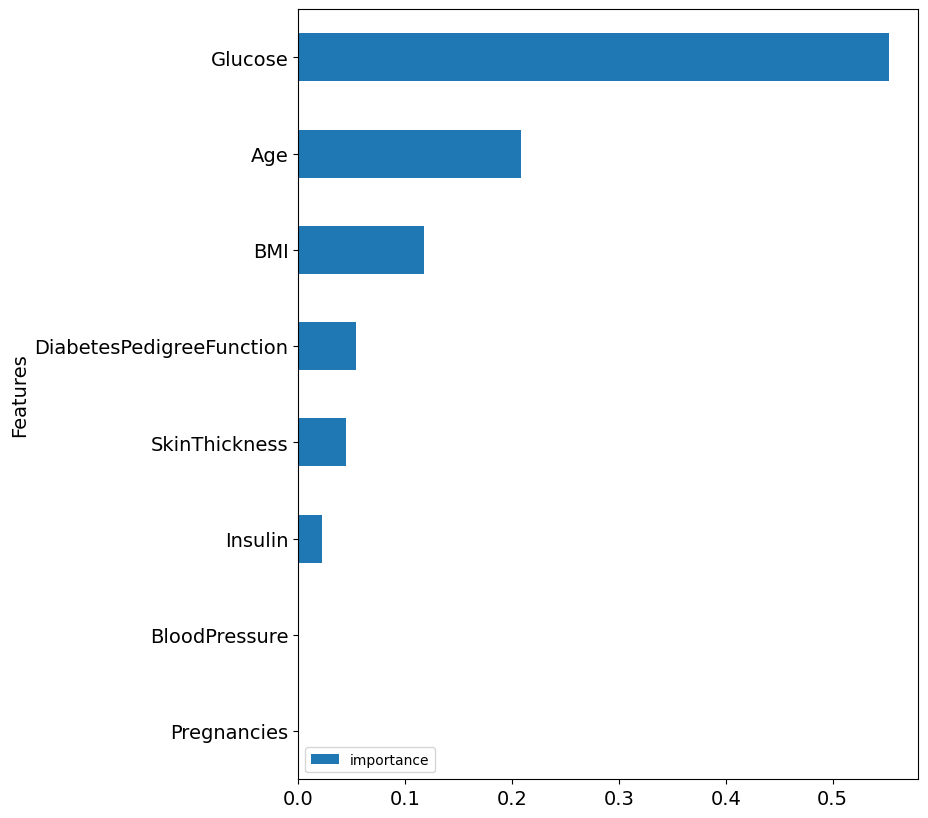

<Figure size 640x480 with 0 Axes>



Model Metrics..........       Training     Validation
Observations...........            576            192
Features...............              8              8
Maximum Tree Depth.....              4              4
Minimum Leaf Size......              5              5
Minimum split Size.....              2              2
Mean Absolute Error....         0.2755         0.2886
Avg Squared Error......         0.1378         0.1639
Accuracy...............         0.7795         0.7448
Precision..................     0.6588         0.5846
Recall (Sensitivity).......     0.8077         0.6333
Specificity................     0.7636         0.7955
F1-score...................     0.7257         0.6080
Total Misclassifications...        127             49
MISC (Misclassification)...      22.0%          25.5%
     class 0...............      23.6%          20.5%
     class 1...............      19.2%          36.7%


Training                  Class     Class
Confusion Matrix              0     

In [132]:
""" ************************************************************************ """
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from copy import deepcopy

print("\n*********************************************************************")
print("***** DECISION TREE OPTIMIZATION USING N-FOLD CROSS-VALIDATION ******")
print("*********************************************************************")
y  = encoded_db_data[target]  # Use unencoded values for target. Sklearn uses these labels
X  = encoded_db_data.drop(target, axis=1)
candidate_depths = [2, 3, 4, 5, 6, 7, 8, None]
candidate_splits = [2, 3, 4, 5, 6]
candidate_leafs  = [1, 2, 3, 4, 5]
best_metric      = 0.0  # The metric is F1, which ranges between 0 and 1
metric           = 'f1'
n_folds = 4  # Number of folds for cross-validation

# Hyperparameter optimization loop
for depth in candidate_depths:
    for split in candidate_splits:
        for leaf in candidate_leafs:
            dt = DecisionTreeClassifier(max_depth=depth,
                                        min_samples_split=split,
                                        min_samples_leaf=leaf,
                                        random_state=12345)
            score = cross_val_score(dt, X, y, cv=n_folds, scoring=metric)
            f1    = np.mean(score)
            std   = np.std(score)
            if f1 > best_metric:
                best_metric = f1
                best_tree   = deepcopy(dt)
                print("\nDecision Tree for Depth=", depth, "Min Split=", split,
                      "Min Leaf Size=", leaf)
                print("{:.<18s}{:>6s}{:>13s}".format("Metric", "Mean", "Std. Dev."))
                print("{:.<18s}{:>7.4f}{:>10.4f}".format("F1V: ", f1, std))

# Fit the best decision tree on the training set
best_tree.fit(Xt, yt)
tree_levels = best_tree.get_depth()
tree_leafs  = best_tree.tree_.n_leaves
print("\nThe Best Tree has", tree_levels, "Levels and", tree_leafs, "Leaves")
print("\nBEST DECISION TREE SELECTED USING", n_folds, "-FOLD CV WITH F1V=", round(best_metric, 3))
tree_parms = best_tree.get_params()
print("Max Depth=", tree_parms['max_depth'])
print("Min Samples Split=", tree_parms['min_samples_split'])
print("Min Samples Leaf=", tree_parms['min_samples_leaf'])

# Display feature importance (Assuming `tree_classifier.display_importance` is defined)
tree_classifier.display_importance(best_tree, Xt.columns, top=20, plot=True)

# Display split metrics (Assuming `tree_classifier.display_split_metrics` is defined)
tree_classifier.display_split_metrics(best_tree, Xt, yt, Xv, yv)

# Cross-validation on the whole dataset with cv=4 and detailed metrics
print("\n***** CROSS-VALIDATION RESULTS ON THE WHOLE DATASET (CV=4) *****\n")

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Perform 4-fold cross-validation on the entire dataset
cv_results = cross_validate(best_tree, X, y, cv=4, scoring=scoring, return_train_score=False)

# Calculate and display mean cross-validation results
cv_metrics = {
    'Accuracy (%)': np.mean(cv_results['test_accuracy']) * 100,
    'Precision (%)': np.mean(cv_results['test_precision']) * 100,
    'Recall (%)': np.mean(cv_results['test_recall']) * 100,
    'F1 Score (%)': np.mean(cv_results['test_f1']) * 100
}

# Display cross-validation metrics
print(f"Mean Accuracy: {cv_metrics['Accuracy (%)']:.2f}%")
print(f"Mean Precision: {cv_metrics['Precision (%)']:.2f}%")
print(f"Mean Recall: {cv_metrics['Recall (%)']:.2f}%")
print(f"Mean F1 Score: {cv_metrics['F1 Score (%)']:.2f}%")

In [133]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=4, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.71


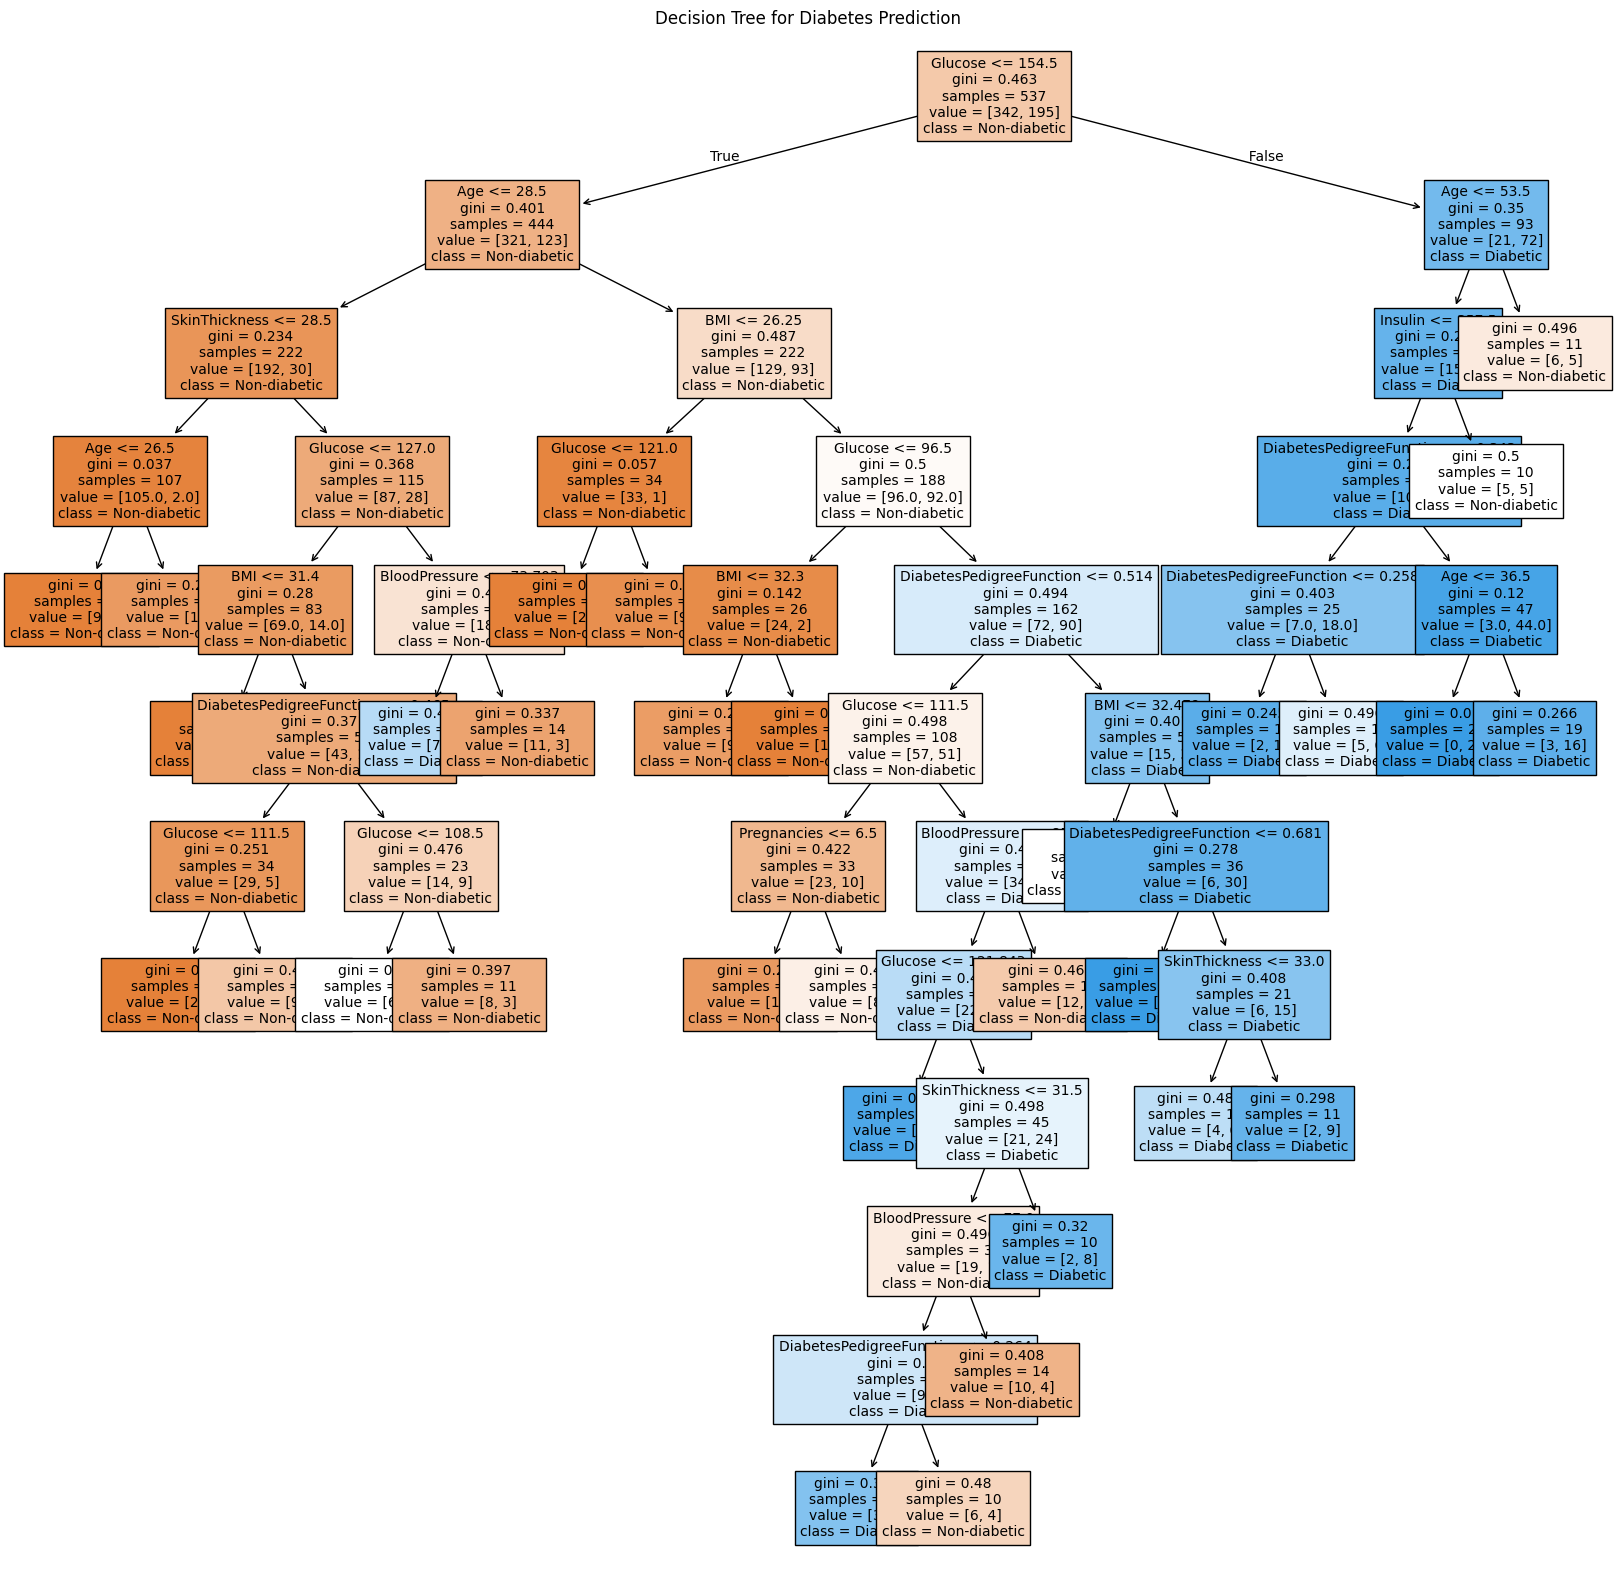

In [134]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Train the final model with the best parameters
best_dt = grid_search.best_estimator_

# Fit the model
best_dt.fit(X_train, y_train)
# Visualize the decision tree
plt.figure(figsize=(20,20))
plot_tree(best_dt, filled=True, feature_names=predictors, class_names=['Non-diabetic', 'Diabetic'], fontsize=10)
plt.title("Decision Tree for Diabetes Prediction")
plt.show()


In [135]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Ensure Train-Test Split Matches
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12345)

# Step 2: Apply Stepwise Feature Selection and Ensure Masks Align
# Perform stepwise selection on the training set
selected_features_mask = stepwise_selection(X_train, y_train, method='forward',
                                            n_features_to_select=12,
                                            feature_names=X.columns)

# Ensure selected features are correctly applied to both train and test sets
X_train_selected = X_train.iloc[:, selected_features_mask]
X_test_selected = X_test.iloc[:, selected_features_mask]

# Step 3: Reset Indices to Ensure Consistent Alignment
X_train_selected = X_train_selected.reset_index(drop=True)
X_test_selected = X_test_selected.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Step 4: Define a Function to Calculate Metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])) * 100
    miscalculations = (conf_matrix[0, 1] + conf_matrix[1, 0]) / len(y_true) * 100

    return accuracy, precision, recall, specificity, f1, miscalculations

# Step 5: Train Models and Compare Metrics

def model_comparison(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)

    # Predict on both train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)

    # Create a comparison DataFrame
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy (%)', 'Precision (%)', 'Recall (Sensitivity) (%)',
                   'Specificity (%)', 'F1 Score (%)', 'Miscalculations (%)'],
        f'{model_name} (Train)': train_metrics,
        f'{model_name} (Test)': test_metrics
    })

    return comparison_df

# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs')
logistic_comparison = model_comparison(logistic_model, X_train_selected, X_test_selected,
                                       y_train, y_test, "Logistic Regression")

# Decision Tree Model
best_tree.fit(X_train_selected, y_train)  # Use the selected features
tree_comparison = model_comparison(best_tree, X_train_selected, X_test_selected,
                                   y_train, y_test, "Decision Tree")
# Step 6: Combine All Comparisons
comparison_df = pd.concat([logistic_comparison,
                           tree_comparison.iloc[:, 1:]], axis=1)

print("*******************************************************************")
print("Model Performance Comparison:")
print("*******************************************************************")
print(comparison_df)

Selected features (forward): Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
*******************************************************************
Model Performance Comparison:
*******************************************************************
                     Metric  Logistic Regression (Train)  \
0              Accuracy (%)                    75.605214   
1             Precision (%)                    70.253165   
2  Recall (Sensitivity) (%)                    56.923077   
3           Specificity (%)                    86.257310   
4              F1 Score (%)                    62.889518   
5       Miscalculations (%)                    24.394786   

   Logistic Regression (Test)  Decision Tree (Train)  Decision Tree (Test)  
0                   81.385281              77.839851             75.757576  
1                   80.000000              65.573770             60.493827  
2  

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=12 > n_features=8. There will be no feature selection and all features will be kept.
  warnings.warn(


# **ROC CURVE**


****************** Logistic Regression ******************
                     Metric  Training Set   Test Set
0              Accuracy (%)     75.605214  81.385281
1             Precision (%)     70.253165  80.000000
2  Recall (Sensitivity) (%)     56.923077  54.794521
3           Specificity (%)     86.257310  93.670886
4                   AUC (%)     83.075424  86.214670
5     Misclassification (%)     24.394786  18.614719

****************** Decision Tree ******************
                     Metric  Training Set   Test Set
0              Accuracy (%)     80.819367  80.952381
1             Precision (%)     82.857143  78.431373
2  Recall (Sensitivity) (%)     59.487179  54.794521
3           Specificity (%)     92.982456  93.037975
4                   AUC (%)     89.886790  80.475117
5     Misclassification (%)     19.180633  19.047619


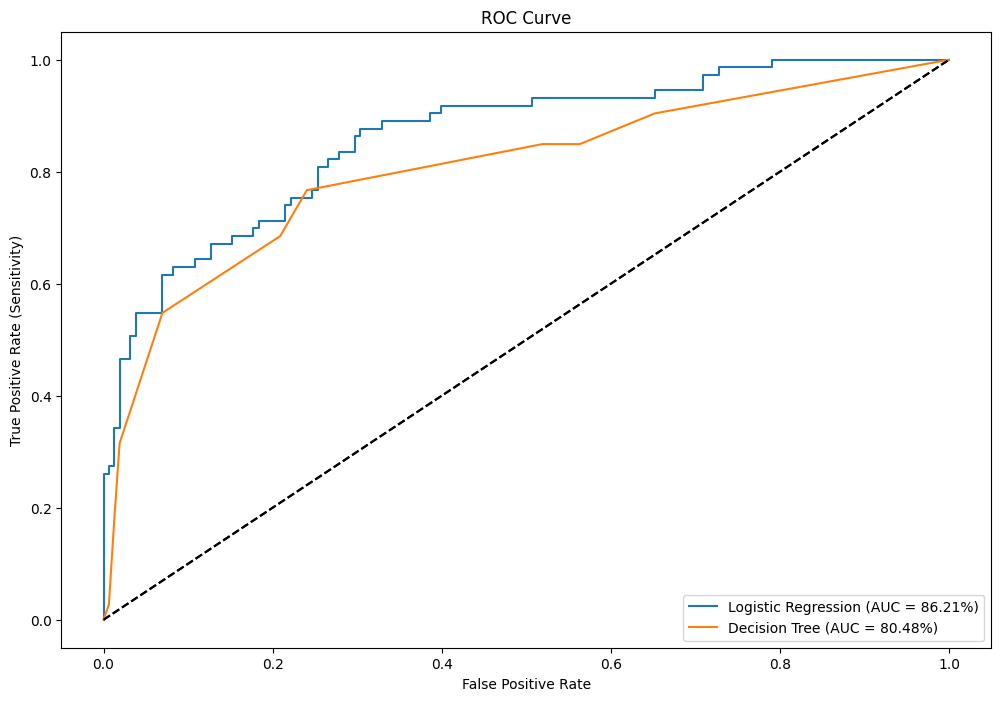

In [136]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate accuracy, precision, recall, specificity, AUC, and misclassification percentage."""
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100  # Sensitivity
    specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])) * 100
    auc_score = roc_auc_score(y_true, y_prob) * 100
    misclassification = ((conf_matrix[0, 1] + conf_matrix[1, 0]) / len(y_true)) * 100

    return accuracy, precision, recall, specificity, auc_score, misclassification, conf_matrix

# Function to evaluate and display results for a model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate the model, and display results."""
    # Train the model
    model.fit(X_train, y_train)

    # Predictions and probabilities
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics for both training and test sets
    train_metrics = calculate_metrics(y_train, y_train_pred, y_train_prob)
    test_metrics = calculate_metrics(y_test, y_test_pred, y_test_prob)

    # Display metrics side-by-side
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy (%)', 'Precision (%)', 'Recall (Sensitivity) (%)',
                   'Specificity (%)', 'AUC (%)', 'Misclassification (%)'],
        'Training Set': train_metrics[:-1],  # Exclude confusion matrix
        'Test Set': test_metrics[:-1]        # Exclude confusion matrix
    })

    print(f"\n****************** {model_name} ******************")
    print(metrics_df)

    # Plot ROC Curve for Test Set
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {test_metrics[4]:.2f}%)')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

# Initialize models
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs')
decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=12345)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2,
                                       min_samples_leaf=1, random_state=12345)

# Evaluate and plot ROC for each model
plt.figure(figsize=(12, 8))

# Logistic Regression
evaluate_model(logistic_model, X_train_selected, y_train, X_test_selected, y_test, "Logistic Regression")

# Decision Tree
evaluate_model(decision_tree, X_train, y_train, X_test, y_test, "Decision Tree")


# Display ROC Curves
plt.show()


# **OVERFITTING ANALYSIS**



******* Overfitting Check Across Models *******

************* Overfitting Analysis: Logistic Regression *************
                     Metric  Training Set   Test Set  Overfitting %
0              Accuracy (%)     75.605214  81.385281      -5.780067
1             Precision (%)     70.253165  80.000000      -9.746835
2  Recall (Sensitivity) (%)     56.923077  54.794521       2.128556
3           Specificity (%)     86.257310  93.670886      -7.413576
4                   AUC (%)     83.075424  86.214670      -3.139246
5     Misclassification (%)     24.394786  18.614719       5.780067

************* Overfitting Analysis: Decision Tree *************
                     Metric  Training Set   Test Set  Overfitting %
0              Accuracy (%)     80.819367  80.952381      -0.133014
1             Precision (%)     82.857143  78.431373       4.425770
2  Recall (Sensitivity) (%)     59.487179  54.794521       4.692659
3           Specificity (%)     92.982456  93.037975      -0.05551

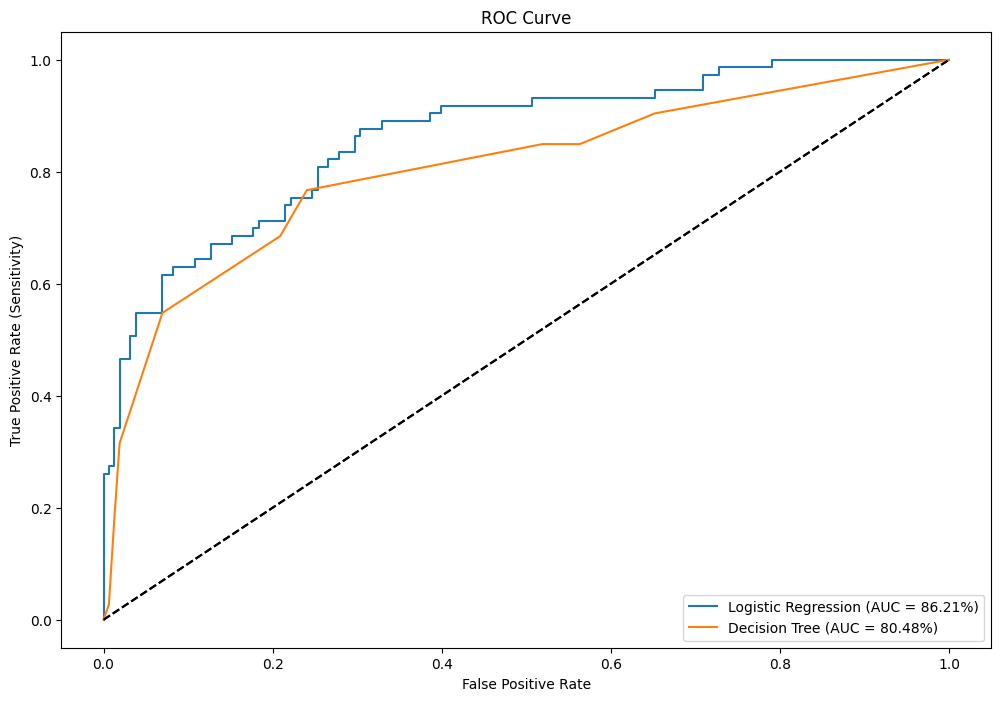

In [137]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, f1_score
)
import matplotlib.pyplot as plt
import pandas as pd

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate accuracy, precision, recall, specificity, AUC, and misclassification percentage."""
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100  # Sensitivity
    specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])) * 100
    auc_score = roc_auc_score(y_true, y_prob) * 100
    misclassification = ((conf_matrix[0, 1] + conf_matrix[1, 0]) / len(y_true)) * 100

    return accuracy, precision, recall, specificity, auc_score, misclassification

# Function to compute overfitting metrics
def compute_overfitting(train_metrics, test_metrics, model_name):
    """Compute overfitting by calculating the difference between training and test metrics."""
    overfitting_df = pd.DataFrame({
        'Metric': ['Accuracy (%)', 'Precision (%)', 'Recall (Sensitivity) (%)',
                   'Specificity (%)', 'AUC (%)', 'Misclassification (%)'],
        'Training Set': train_metrics,
        'Test Set': test_metrics,
        'Overfitting %': [(train - test) for train, test in zip(train_metrics, test_metrics)]
    })

    print(f"\n************* Overfitting Analysis: {model_name} *************")
    print(overfitting_df)

# Function to evaluate and print metrics with overfitting analysis
def evaluate_and_check_overfitting(model, X_train, y_train, X_test, y_test, model_name):
    """Train, evaluate the model, and check for overfitting."""
    # Train the model
    model.fit(X_train, y_train)

    # Predictions and probabilities
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics for training and test sets
    train_metrics = calculate_metrics(y_train, y_train_pred, y_train_prob)
    test_metrics = calculate_metrics(y_test, y_test_pred, y_test_prob)

    # Print metrics side-by-side
    compute_overfitting(train_metrics, test_metrics, model_name)

    # Plot ROC curve for the test set
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {test_metrics[4]:.2f}%)')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

# Initialize models
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs')
decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=12345)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2,
                                       min_samples_leaf=1, random_state=12345)

# Evaluate models and print overfitting analysis
plt.figure(figsize=(12, 8))

print("\n\n******* Overfitting Check Across Models *******")

# Logistic Regression
evaluate_and_check_overfitting(logistic_model, X_train_selected, y_train, X_test_selected, y_test, "Logistic Regression")

# Decision Tree
evaluate_and_check_overfitting(decision_tree, X_train, y_train, X_test, y_test, "Decision Tree")

# Show ROC curves for all models
plt.show()


In [138]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd

# Function to calculate relevant metrics
def calculate_metrics_for_overfitting(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score."""
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100

    return accuracy, precision, recall, f1

# Function to train and evaluate the model on both training and test sets
def evaluate_overfitting(model, X_train, y_train, X_test, y_test, model_name):
    """Train the model and compare performance on training vs. test data."""
    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics for training and test sets
    train_metrics = calculate_metrics_for_overfitting(y_train, y_train_pred)
    test_metrics = calculate_metrics_for_overfitting(y_test, y_test_pred)

    # Display metrics side-by-side
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy (%)', 'Precision (%)', 'Recall (Sensitivity) (%)', 'F1 Score (%)'],
        'Training Set': train_metrics,
        'Test Set': test_metrics
    })

    print(f"\n************ {model_name} Performance ************")
    print(metrics_df)

    # Check for Overfitting: Large gap between training and test set performance
    if train_metrics[0] - test_metrics[0] > 10:
        print(f"\nWarning: {model_name} may be overfitting! Large gap in accuracy between training and test sets.\n")
    else:
        print(f"\n{model_name} does not show significant signs of overfitting.\n")

# Initialize the models
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs')
decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=12345)

# Evaluate each model for overfitting
evaluate_overfitting(logistic_model, X_train_selected, y_train, X_test_selected, y_test, "Logistic Regression")
evaluate_overfitting(decision_tree, X_train, y_train, X_test, y_test, "Decision Tree")


************ Logistic Regression Performance ************
                     Metric  Training Set   Test Set
0              Accuracy (%)     75.605214  81.385281
1             Precision (%)     70.253165  80.000000
2  Recall (Sensitivity) (%)     56.923077  54.794521
3              F1 Score (%)     62.889518  65.040650

Logistic Regression does not show significant signs of overfitting.


************ Decision Tree Performance ************
                     Metric  Training Set   Test Set
0              Accuracy (%)     80.819367  80.952381
1             Precision (%)     82.857143  78.431373
2  Recall (Sensitivity) (%)     59.487179  54.794521
3              F1 Score (%)     69.253731  64.516129

Decision Tree does not show significant signs of overfitting.



# **FEATURE IMPORTANCE**

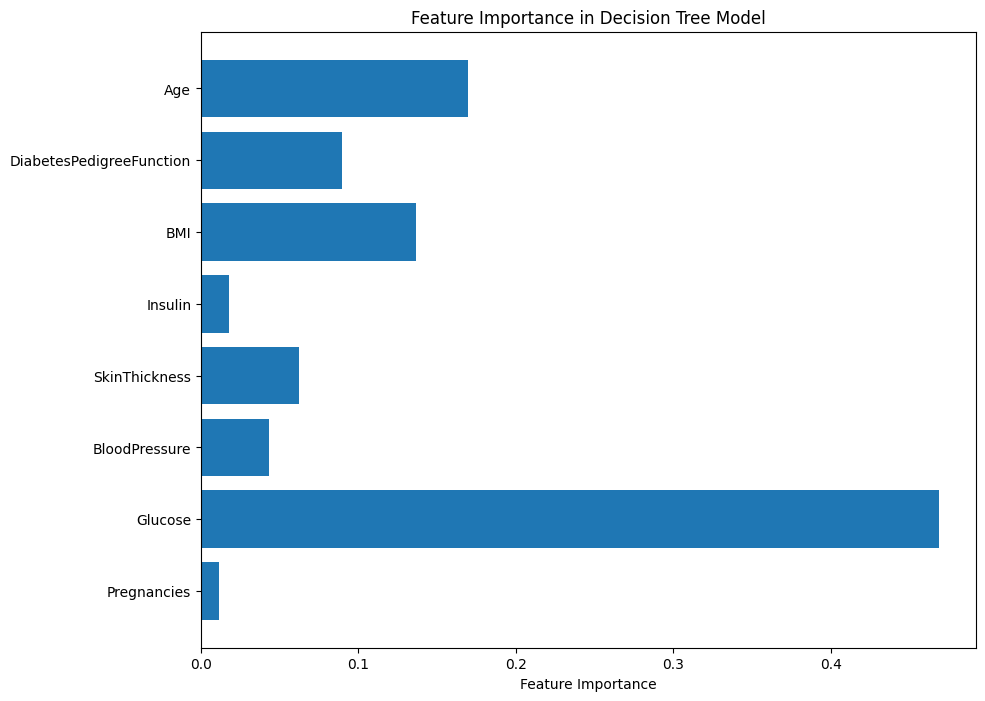

In [139]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importances = best_dt.feature_importances_

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), X_train.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.show()


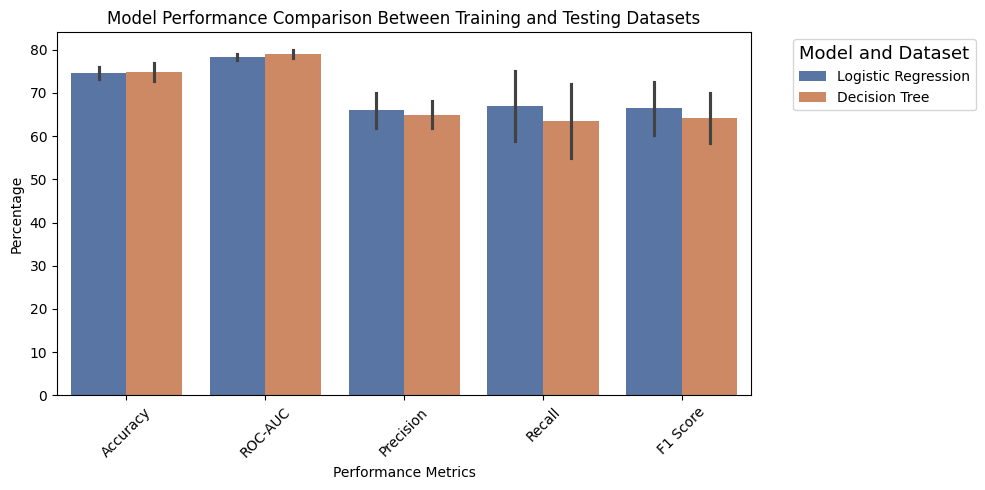

In [140]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = {
    "Model": ["Logistic Regression", "Decision Tree", "Logistic Regression", "Decision Tree"],
    "Dataset": ["Training", "Training", "Testing", "Testing"],
    "Accuracy": [76, 77, 73.16, 72.73],
    "ROC-AUC": [79, 80, 77.69, 78.12],
    "Precision": [70, 68, 61.84, 61.97],
    "Recall": [75, 72, 58.75, 55.00],
    "F1 Score": [72.5, 70, 60.26, 58.28]
}

df = pd.DataFrame(data)

# Melting the DataFrame to make it suitable for sns.barplot
df_melted = df.melt(id_vars=["Model", "Dataset"], var_name="Metric", value_name="Value")

# Creating the plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x="Metric", y="Value", hue="Model", palette="deep", dodge=True)
plt.title('Model Performance Comparison Between Training and Testing Datasets')
plt.ylabel('Percentage')
plt.xlabel('Performance Metrics')
plt.legend(title='Model and Dataset', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [141]:
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np
# Perform cross-validation using 4 folds
n_folds = 4

# Perform cross-validation
cv_results = cross_validate(
    logistic_model,
    Xt,  # The feature matrix
    yt,  # The target vector
    cv=n_folds,  # Number of folds
    scoring=['accuracy', 'precision', 'recall', 'f1'],  # Scoring metrics
    return_train_score=True  # Return train scores as well
)

# Display results from cross-validation in percentage format
print(f"\nBest Logistic model selected using {n_folds}-fold cross-validation:")
print(f"Mean accuracy: {np.mean(cv_results['test_accuracy']) * 100:.2f}%")
print(f"Mean precision: {np.mean(cv_results['test_precision']) * 100:.2f}%")
print(f"Mean recall: {np.mean(cv_results['test_recall']) * 100:.2f}%")
print(f"Mean F1 score: {np.mean(cv_results['test_f1']) * 100:.2f}%")


Best Logistic model selected using 4-fold cross-validation:
Mean accuracy: 75.00%
Mean precision: 69.06%
Mean recall: 55.77%
Mean F1 score: 61.31%
